In [2]:
from sklearn import tree
from sklearn.model_selection import train_test_split
import pandas as pd
import math
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# CART Algo

In [95]:
treeGraph = nx.Graph()

In [4]:
def new_node(node):
    global treeGraph
    if node not in treeGraph.nodes():
        treeGraph.add_node(node)
        print("\nadding ", node , "as new node\n")

In [5]:
def new_edge(node1,node2):
    global treeGraph
    treeGraph.add_edge(node1,node2)
    print("\nadding edge", node1 , " --> ", node2)

In [6]:
def most_freq_value(data,attr):
    return data[attr].describe()["top"]
    

In [7]:
def gini_calc(data,targetAttribute):
    
    totalPop = len(data[targetAttribute])
    prob = data[targetAttribute].value_counts()/totalPop
    gini = prob.map(lambda x : x*x*math.log2(x)).sum()
    
    
    # returning entropy
    return gini,totalPop
    

In [8]:
def gini(data,targetAttribute,feature):
    """returns the info gain"""
    childNodes = data[feature].unique()
    childGini = {}
    splitGini = 0
    #calculate entropy of parent node
    #parentEntropy,parentPop = entropy_calc(data,targetAttribute)
    parentPop = len(data[targetAttribute])
    #calculate gini of each child
    for child in childNodes:
        childData = data[data[feature]==child]
        childGini[child] = gini_calc(childData,targetAttribute)
    
    # calculating gini of the split
    for child2 in childGini.keys():
        splitGini += (childGini[child2][0]*childGini[child2][1]/parentPop)
    
    return splitGini
        
    

In [9]:
def best_attribute_func(data,targetAttribute,attributes,choice_func):
    # for all possible splits/attributes calculate the metric given by the choice function.
    metric = {}
    for feature in attributes:
        metric[choice_func(data,targetAttribute,feature)] = feature
    
    #return the feature with the highest value(gini)
    return metric[sorted(metric,reverse=True)[0]]
        
    
        
    

In [10]:
def CART_classifier(data,targetAttribute,attributes,choice_func,last_node="root"):
    """Returns a decision tree using CART algorithm """
    global treeGraph
    data = data[:]
    targetVals = data[targetAttribute]
    
    freqVals = most_freq_value(data,targetAttribute)
    
    
    # Recursion Stop 1
    # if dataset is empty or list of attributes is empty,
    # return the most frequent values of the targetAttribute
    if len(data)==0 or (len(attributes)-1) <= 0:
        new_node(freqVals)
        new_edge(last_node,freqVals)
        return freqVals
    
    # Recursion Stop 2
    # if all values have same classification,
    # return the node root value
    elif len(targetVals.unique()) == 1:
        label = targetVals.unique()[0]
        new_node(label)
        new_edge(last_node,freqVals)
        return label
    
    
    #otherwise create a new decision tree :
    
    else :
        # find the best attribute to split the data,
        # on grounds of max info gain
        bestAttr = best_attribute_func(data,targetAttribute,attributes,choice_func)
        new_node(bestAttr)
        new_edge(last_node,bestAttr)
        
        #adding node to the graph
        
        tree = {bestAttr : {}}
        
        # creating a decision tree/node for all unique values of the bestAttr
        for value in data[bestAttr].unique():
            print("\n",bestAttr,"\t",value)
            
            
            new_node(value)
            new_edge(bestAttr,value)
            last_node = value
            
            subtree = CART_classifier(data[data[bestAttr] == value],\
                          targetAttribute,\
                          attributes.difference([bestAttr]),\
                          choice_func,last_node)
            print("Subtree : \t",subtree)
            tree[bestAttr][value] = subtree
           
    return tree
        
    
    
    

In [115]:
def CART_classifier_fit(X_train,y_train):
    """CART_classifier(data,targetAttribute,attributes,choice_func=gini)"""
    global treeGraph
    treeGraph = nx.Graph()
    data = pd.concat([X_train,y_train],axis=1)
    return CART_classifier(data,targetAttribute=list(y_train.columns)[0],attributes=X_train.columns,choice_func=gini)
    

### loading data  and testing

## <span style="color:blue"> Test 1</span>

In [39]:
ls

data.csv  decision tree - CART.ipynb  README.md  train.csv*


In [65]:
df = pd.read_csv("data.csv") #this is a small data set, better for an unoptimized tree algo

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 5 columns):
Age               20 non-null object
Education         20 non-null object
Income            20 non-null object
Marital Status    20 non-null object
Purchase?         20 non-null object
dtypes: object(5)
memory usage: 880.0+ bytes


In [67]:
df.head(3)

,Age,Education,Income,Marital Status,Purchase?
0,36-55,master's,high,single,will buy
1,18-35,high school,low,single,won't buy
2,36-55,master's,low,single,will buy


##### <span style="color:green">for testing purposes we will use the age , Education , income  marital status, and convert purchase into a categorical variable based on the median</span>

#### getting dummy codes for all 

In [68]:
#id_var = ["User_ID"]
target_var =["Purchase?"]
#drop_features = ["Product_ID","Product_Category_1","Product_Category_2","Product_Category_3"]
features = df.columns.difference(target_var)

In [69]:
features

Index(['Age', 'Education', 'Income', 'Marital Status'], dtype='object')

In [74]:
# creating dummy codes for all categorical variables
temp = pd.DataFrame()

temp = pd.get_dummies(df[list(features)])

# changing dummy values from 0,1 to column_category_value
# changing these dummy values to the form of column_category_value 
# helps in creating separate nodes in the graph

temp = temp.apply(lambda x : x.map(lambda y : x.name+"_"+str(y))) 

df = pd.concat([df,temp],axis=1)

In [18]:
df.head(1)

,Age,Education,Income,Marital Status,Purchase?,Age_36-55,Age_18-35,Age_< 18,Age_> 55,Education_master's,Education_high school,Education_bachelor's,Income_high,Income_low,Marital Status_single,Marital Status_married
0,36-55,master's,high,single,will buy,Age_36-55_0.0,Age_18-35_1.0,Age_< 18_0.0,Age_> 55_0.0,Education_master's_0.0,Education_high school_0.0,Education_bachelor's_1.0,Income_high_1.0,Income_low_0.0,Marital Status_single_0.0,Marital Status_married_1.0


In [75]:
# dropping the original columns

In [76]:
list(features)

['Age', 'Education', 'Income', 'Marital Status']

In [77]:
df = df.drop(list(features),axis=1)

In [78]:
df.columns

Index(['Purchase?', 'Age_18-35', 'Age_36-55', 'Age_< 18', 'Age_> 55',
       'Education_bachelor's', 'Education_high school', 'Education_master's',
       'Income_high', 'Income_low', 'Marital Status_married',
       'Marital Status_single'],
      dtype='object')

In [79]:

target_var =["Purchase?"]
features = df.columns.difference(target_var)

In [80]:
features

Index(['Age_18-35', 'Age_36-55', 'Age_< 18', 'Age_> 55',
       'Education_bachelor's', 'Education_high school', 'Education_master's',
       'Income_high', 'Income_low', 'Marital Status_married',
       'Marital Status_single'],
      dtype='object')

In [81]:
X_train, X_test, y_train, y_test = train_test_split(df[features],df[target_var],test_size = 0.25)

## <span style="color:green"> this creates a decision tree in the form of a dictionary of dictionaries</span>
* it also produces a graph of all connections in the decision tree

In [96]:
CART_classifier_tree = CART_classifier_fit(X_train,y_train)


adding  Marital Status_single as new node


adding edge root  -->  Marital Status_single

 Marital Status_single 	 Marital Status_single_0.0

adding  Marital Status_single_0.0 as new node


adding edge Marital Status_single  -->  Marital Status_single_0.0

adding  Education_bachelor's as new node


adding edge Marital Status_single_0.0  -->  Education_bachelor's

 Education_bachelor's 	 Education_bachelor's_0.0

adding  Education_bachelor's_0.0 as new node


adding edge Education_bachelor's  -->  Education_bachelor's_0.0

adding  Age_36-55 as new node


adding edge Education_bachelor's_0.0  -->  Age_36-55

 Age_36-55 	 Age_36-55_1.0

adding  Age_36-55_1.0 as new node


adding edge Age_36-55  -->  Age_36-55_1.0

adding  won't buy as new node


adding edge Age_36-55_1.0  -->  won't buy
Subtree : 	 won't buy

 Age_36-55 	 Age_36-55_0.0

adding  Age_36-55_0.0 as new node


adding edge Age_36-55  -->  Age_36-55_0.0

adding  will buy as new node


adding edge Age_36-55_0.0  -->  will buy
Su

## Drawing a graph

In [100]:
nodeNo = len(treeGraph.nodes())

In [116]:
treeGraph.nodes()

['Marital Status_single_0.0',
 'Age_< 18_0.0',
 'Marital Status_single_1.0',
 'Age_< 18',
 'Income_low',
 'Age_36-55',
 'Age_< 18_1.0',
 "won't buy",
 'Age_36-55_1.0',
 'root',
 "Education_bachelor's_1.0",
 'Age_36-55_0.0',
 'Income_low_1.0',
 "Education_bachelor's",
 'Income_low_0.0',
 'Marital Status_single',
 "Education_bachelor's_0.0",
 'will buy']

In [98]:
treeGraph.edges()


[('Marital Status_single_0.0', 'Marital Status_single'),
 ('Marital Status_single_0.0', "Education_bachelor's"),
 ('Age_< 18_0.0', 'Age_< 18'),
 ('Age_< 18_0.0', 'will buy'),
 ('Marital Status_single_1.0', 'Age_< 18'),
 ('Marital Status_single_1.0', 'Marital Status_single'),
 ('Age_< 18', 'Age_< 18_1.0'),
 ('Income_low', 'Income_low_0.0'),
 ('Income_low', 'Age_< 18_1.0'),
 ('Income_low', 'Income_low_1.0'),
 ('Age_36-55', 'Age_36-55_0.0'),
 ('Age_36-55', "Education_bachelor's_0.0"),
 ('Age_36-55', 'Age_36-55_1.0'),
 ("won't buy", 'Income_low_0.0'),
 ("won't buy", "Education_bachelor's_1.0"),
 ("won't buy", 'Age_36-55_1.0'),
 ('root', 'Marital Status_single'),
 ("Education_bachelor's_1.0", "Education_bachelor's"),
 ('Age_36-55_0.0', 'will buy'),
 ('Income_low_1.0', 'will buy'),
 ("Education_bachelor's", "Education_bachelor's_0.0")]

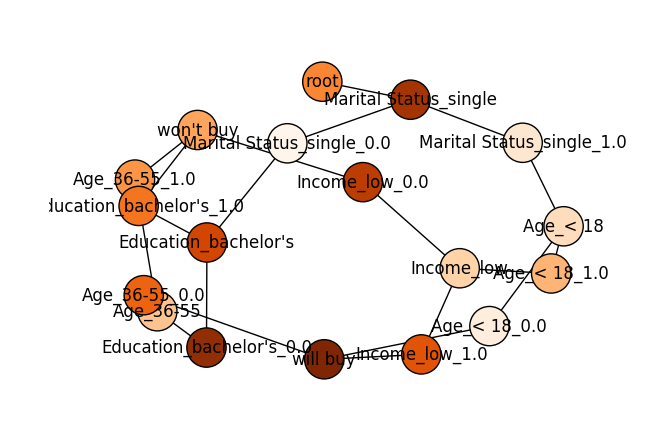

In [117]:
nx.draw_spring(treeGraph,with_labels=True,node_color = range(nodeNo),cmap = plt.cm.Oranges,node_size =800)
plt.show()